### Intracellular Ca signalling model

1. Markov state model was built based on "Allosteric Regulation of the P2X4 Recepter Channel Pore Dilation" by Zemkova, Khadra, Rokic, Tvrdonova, Sherman, and Stojikovic.

- This is the 13-state model

2. The relative contribution of Ca to total inward current in the cell (HEK293) was reported to be 8.24 +- 0.36% by Garcia-Guzman. -> This may need to be adjusted for rat P2X4 channel
3. The diameter of HEK293 cell body is approximated to be 13 microns -> r = 6.5 microns
4. The diameter of microglia cell body is approximated to be 5.2 microns -> r = 2.6 microns (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4213482/)
5. Beyond the buffering effects of calmodulin was handled by Rachel
6. The intermediate product of this code is "intracellular Ca transient"
7. The final outcome of this code is "TNF-alpha transient"

*1. Markov state model was built based on "Dual gating mechanism and function of P2X7 receptor channels" by Khadra and modified to adjust the current profile from the activation by BzATP to ATP. 

- This is the 12-state model
- BzATP = 4.11863563exp(ATP*0.00479906) 

#### Limitations & Assumptions

1. NFAT terms with no detail connection to buffering effects.

2. No TNF terms

#### NFATNn Profile & TNF-alpha release

1. Even after adjusting some of parameters, there is no supporting data to explain or indicating the scale of concentrations. 
2. The pattern of profile will be used as a switch of TNF-alpha release and the concentration of NFATNn will not influence on the degree of release
3. The release of TNF-alpha will be fully assumed based on general RNA transcription and translation. https://www.mathworks.com/help/simbio/gs/-model-a-gene-regulation-pathway.html?requestedDomain=true

In [1]:
# Function for integreating ODE and displaying results
import scipy.integrate
from scipy.integrate import odeint
import numpy as np
import matplotlib.pylab as plt
import math
from math import exp
from scipy.interpolate import spline
import pickle as pk
%matplotlib inline

# Importing the microglia related packages
import data_v3 as dt      # Data sorting code
import TNFa as ta      # TNFa release code
import NFAT as nt      # NFAT cycle code
import MSMp2x4v2 as p4   # Markov State Model for P2X4 channel
import MSMp2x7v2 as p7   # Markov State Model for P2X7 channel
import SBbuffers as bf # Buffers (Fura-2, Calmodulin, and Calsequestrin) code
import SERCAER as er   # SERCA Pump code
import NCX as nx       # Na/Ca exchanger code
import calculator_v6 as ca

import numpy.random as npr
# normal random distribution
from numpy.random import normal as nprn
# uniform random distribution
from numpy.random import uniform as npru

In [2]:
# 1 sec of stimulation in 0.1 Hz
iters1 = np.arange(2000)
interval = 10
st = 1
ATP = []
timeATP = []
y = 0.6
dummy = np.nan
for i in iters1:
    ti = i*interval
    tf = (1+i)*interval-st
    trs = scipy.linspace(ti,tf,(interval*1))
    iters2 = np.arange(np.shape(trs)[0])
    for j in iters2:
        ATP = np.append(ATP,dummy)
    tst=scipy.linspace(tf,(tf+st),(st*2))
    iters3 = np.arange(np.shape(tst)[0])
    for k in iters3:
        ATP = np.append(ATP,0.1)
    timeATP = np.append(timeATP,trs)
    timeATP = np.append(timeATP,tst)

In [23]:
results1 = pk.load(open("/home/bending456/2018Microglia/Microglia2018/temp/1mMATP_01Hz.p","rb"))
results2 = pk.load(open("/home/bending456/2018Microglia/Microglia2018/temp/1mMATP_01Hz_50permorep2x4_.p","rb"))
results3 = pk.load(open("/home/bending456/2018Microglia/Microglia2018/temp/1mMATP_01Hz_50permorep2x7_.p","rb"))
results4 = pk.load(open("/home/bending456/2018Microglia/Microglia2018/temp/1mMATP_01Hz_100permorep2x4_.p","rb"))
results5 = pk.load(open("/home/bending456/2018Microglia/Microglia2018/temp/1mMATP_01Hz_100permorep2x7_.p","rb"))
results6 = pk.load(open("/home/bending456/2018Microglia/Microglia2018/temp/1mMATP_01Hz_50permore_.p","rb"))

Ca1 = results1[0]
Ca2 = results2[0]
Ca3 = results3[0]
Ca4 = results4[0]
Ca5 = results5[0]
Ca6 = results6[0]

CaMCN1 = results1[7]
CaMCN2 = results2[7]
CaMCN3 = results3[7]
CaMCN4 = results4[7]
CaMCN5 = results5[7]
CaMCN6 = results6[7]

NFATNn1 = results1[36]
NFATNn2 = results2[36]
NFATNn3 = results3[36]
NFATNn4 = results4[36]
NFATNn5 = results5[36]
NFATNn6 = results6[36]

TNFa1 = results1[40]
TNFa2 = results2[40]
TNFa3 = results3[40]
TNFa4 = results4[40]
TNFa5 = results5[40]
TNFa6 = results6[40]

TNFaCa1 = results1[41]
TNFaCa2 = results2[41]
TNFaCa3 = results3[41]
TNFaCa4 = results4[41]
TNFaCa5 = results5[41]
TNFaCa6 = results6[41]

TNFaG1 = results1[42]
TNFaG2 = results2[42]
TNFaG3 = results3[42]
TNFaG4 = results4[42]
TNFaG5 = results5[42]
TNFaG6 = results6[42]

TNFat1 = results1[43]
TNFat2 = results2[43]
TNFat3 = results3[43]
TNFat4 = results4[43]
TNFat5 = results5[43]
TNFat6 = results6[43]

time1 = results1[44]
time2 = results2[44]
time3 = results3[44]
time4 = results4[44]
time5 = results5[44]
time6 = results6[44]

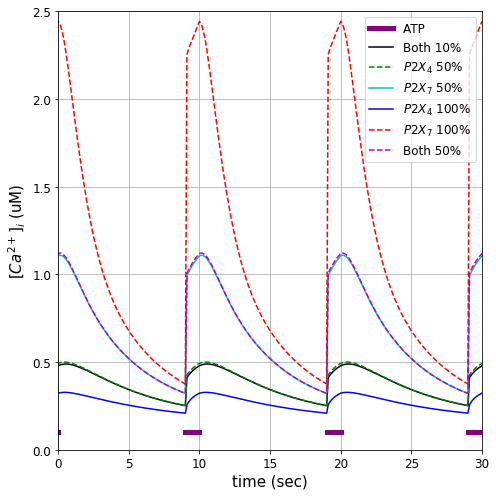

In [9]:
t_int = 30
t_end = 20000
t_new = t_end-t_int
plt.figure(figsize = (7,7))
plt.tick_params(labelsize=12)
plt.plot((timeATP-t_new),ATP,'purple',label='ATP',linewidth=5)
plt.plot((time1-t_new),Ca1*10**6,'k-',label="Both 10%")
plt.plot((time2-t_new),Ca2*10**6,'g--',label="$P2X_{4}$ 50%")
plt.plot((time3-t_new),Ca3*10**6,'c-',label="$P2X_{7}$ 50%")
plt.plot((time4-t_new),Ca4*10**6,'b-',label="$P2X_{4}$ 100%")
plt.plot((time5-t_new),Ca5*10**6,'r--',label="$P2X_{7}$ 100%")
plt.plot((time6-t_new),Ca6*10**6,'m--',label="Both 50%")
plt.xlabel("time (sec)",fontsize=15)
plt.ylabel("$[Ca^{2+}]_{i}$ (uM)",fontsize=15)
plt.legend(loc=0,fontsize=12)
plt.xlim(0,t_int)
plt.ylim(0.0,2.5)
plt.tight_layout()
plt.grid(True)
plt.savefig('CaTransientAcrossDensitiesall.png')

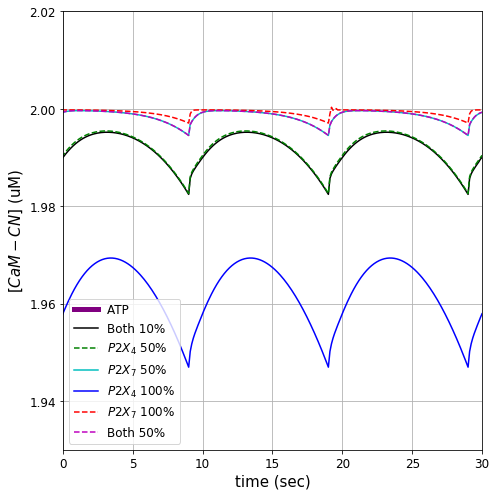

In [14]:
t_int = 30
t_end = 20000
t_new = t_end-t_int
plt.figure(figsize = (7,7))
plt.tick_params(labelsize=12)
plt.plot((timeATP-t_new),ATP,'purple',label='ATP',linewidth=5)
plt.plot((time1-t_new),CaMCN1*10**6,'k-',label="Both 10%")
plt.plot((time2-t_new),CaMCN2*10**6,'g--',label="$P2X_{4}$ 50%")
plt.plot((time3-t_new),CaMCN3*10**6,'c-',label="$P2X_{7}$ 50%")
plt.plot((time4-t_new),CaMCN4*10**6,'b-',label="$P2X_{4}$ 100%")
plt.plot((time5-t_new),CaMCN5*10**6,'r--',label="$P2X_{7}$ 100%")
plt.plot((time6-t_new),CaMCN6*10**6,'m--',label="Both 50%")
plt.xlabel("time (sec)",fontsize=15)
plt.ylabel("$[CaM-CN]$ (uM)",fontsize=15)
plt.legend(loc=0,fontsize=12)
plt.xlim(0,t_int)
plt.ylim(1.93,2.02)
plt.tight_layout()
plt.grid(True)
plt.savefig('CaMCNTransientAcrossDensitiesall.png')

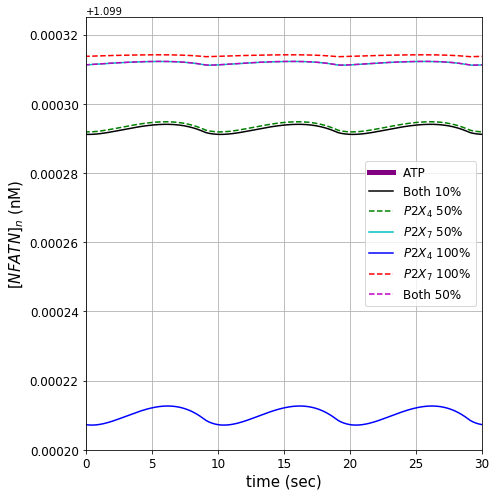

In [21]:
t_int = 30
t_end = 20000
t_new = t_end-t_int
plt.figure(figsize = (7,7))
plt.tick_params(labelsize=12)
plt.plot((timeATP-t_new),ATP,'purple',label='ATP',linewidth=5)
plt.plot((time1-t_new),NFATNn1,'k-',label="Both 10%")
plt.plot((time2-t_new),NFATNn2,'g--',label="$P2X_{4}$ 50%")
plt.plot((time3-t_new),NFATNn3,'c-',label="$P2X_{7}$ 50%")
plt.plot((time4-t_new),NFATNn4,'b-',label="$P2X_{4}$ 100%")
plt.plot((time5-t_new),NFATNn5,'r--',label="$P2X_{7}$ 100%")
plt.plot((time6-t_new),NFATNn6,'m--',label="Both 50%")
plt.xlabel("time (sec)",fontsize=15)
plt.ylabel("$[NFATN]_{n}$ (nM)",fontsize=15)
plt.legend(loc=0,fontsize=12)
plt.xlim(0,t_int)
plt.ylim(1.0992,1.099325)
plt.tight_layout()
plt.grid(True)
plt.savefig('NFATNnTransientAcrossDensitiesall.png')

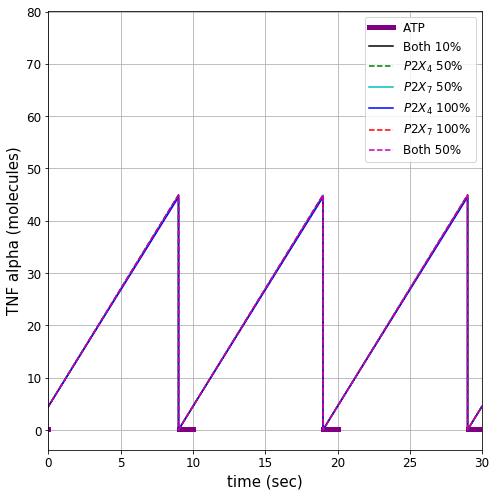

In [24]:
t_int = 30
t_end = 20000
t_new = t_end-t_int
plt.figure(figsize = (7,7))
plt.tick_params(labelsize=12)
plt.plot((timeATP-t_new),ATP,'purple',label='ATP',linewidth=5)
plt.plot((time1-t_new),TNFat1,'k-',label="Both 10%")
plt.plot((time2-t_new),TNFat2,'g--',label="$P2X_{4}$ 50%")
plt.plot((time3-t_new),TNFat3,'c-',label="$P2X_{7}$ 50%")
plt.plot((time4-t_new),TNFat4,'b-',label="$P2X_{4}$ 100%")
plt.plot((time5-t_new),TNFat5,'r--',label="$P2X_{7}$ 100%")
plt.plot((time6-t_new),TNFat6,'m--',label="Both 50%")
plt.xlabel("time (sec)",fontsize=15)
plt.ylabel("TNF alpha (molecules)",fontsize=15)
plt.legend(loc=0,fontsize=12)
plt.xlim(0,t_int)
#plt.ylim(1.0992,1.099325)
plt.tight_layout()
plt.grid(True)
plt.savefig('TNFaTransientAcrossDensitiesall.png')

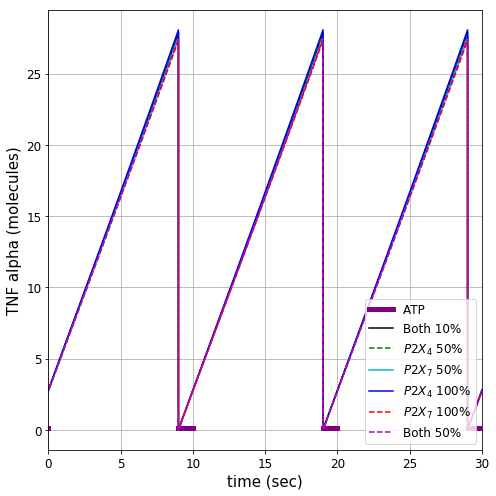

In [25]:
t_int = 30
t_end = 20000
t_new = t_end-t_int
plt.figure(figsize = (7,7))
plt.tick_params(labelsize=12)
plt.plot((timeATP-t_new),ATP,'purple',label='ATP',linewidth=5)
plt.plot((time1-t_new),TNFaG1,'k-',label="Both 10%")
plt.plot((time2-t_new),TNFaG2,'g--',label="$P2X_{4}$ 50%")
plt.plot((time3-t_new),TNFaG3,'c-',label="$P2X_{7}$ 50%")
plt.plot((time4-t_new),TNFaG4,'b-',label="$P2X_{4}$ 100%")
plt.plot((time5-t_new),TNFaG5,'r--',label="$P2X_{7}$ 100%")
plt.plot((time6-t_new),TNFaG6,'m--',label="Both 50%")
plt.xlabel("time (sec)",fontsize=15)
plt.ylabel("TNF alpha (molecules)",fontsize=15)
plt.legend(loc=0,fontsize=12)
plt.xlim(0,t_int)
#plt.ylim(1.0992,1.099325)
plt.tight_layout()
plt.grid(True)
plt.savefig('TNFaGTransientAcrossDensitiesall.png')

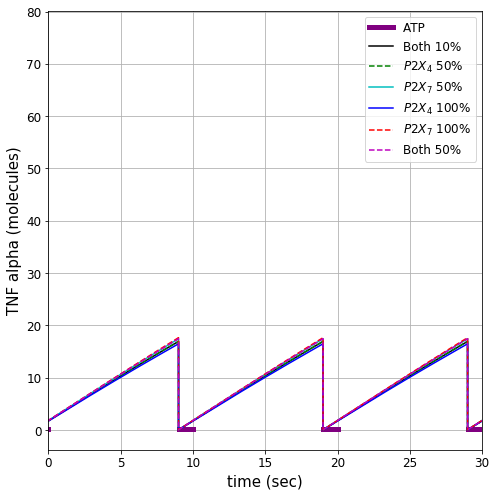

In [27]:
t_int = 30
t_end = 20000
t_new = t_end-t_int
plt.figure(figsize = (7,7))
plt.tick_params(labelsize=12)
plt.plot((timeATP-t_new),ATP,'purple',label='ATP',linewidth=5)
plt.plot((time1-t_new),TNFaCa1,'k-',label="Both 10%")
plt.plot((time2-t_new),TNFaCa2,'g--',label="$P2X_{4}$ 50%")
plt.plot((time3-t_new),TNFaCa3,'c-',label="$P2X_{7}$ 50%")
plt.plot((time4-t_new),TNFaCa4,'b-',label="$P2X_{4}$ 100%")
plt.plot((time5-t_new),TNFaCa5,'r--',label="$P2X_{7}$ 100%")
plt.plot((time6-t_new),TNFaCa6,'m--',label="Both 50%")
plt.xlabel("time (sec)",fontsize=15)
plt.ylabel("TNF alpha (molecules)",fontsize=15)
plt.legend(loc=0,fontsize=12)
plt.xlim(0,t_int)
#plt.ylim(1.0992,1.099325)
plt.tight_layout()
plt.grid(True)
plt.savefig('TNFaCaTransientAcrossDensitiesall.png')

In [9]:
init = (20000-30)*10
final = 200000
Cad1 = Ca1[init:final]
Cad2 = Ca2[init:final] 
Cad3 = Ca3[init:final] 
Cad4 = Ca4[init:final] 
Cad5 = Ca5[init:final] 

CaMCNd1 = CaMCN1[init:final]
CaMCNd2 = CaMCN2[init:final] 
CaMCNd3 = CaMCN3[init:final] 
CaMCNd4 = CaMCN4[init:final] 
CaMCNd5 = CaMCN5[init:final] 

NFATNnd1 = NFATNn1[init:final]
NFATNnd2 = NFATNn2[init:final] 
NFATNnd3 = NFATNn3[init:final] 
NFATNnd4 = NFATNn4[init:final] 
NFATNnd5 = NFATNn5[init:final] 

TNFa_release_totald1 = TNFa_release_total1[init:final]
TNFa_release_totald2 = TNFa_release_total2[init:final] 
TNFa_release_totald3 = TNFa_release_total3[init:final] 
TNFa_release_totald4 = TNFa_release_total4[init:final] 
TNFa_release_totald5 = TNFa_release_total5[init:final] 

In [10]:
Cad21 = Ca21[init:final]
Cad22 = Ca22[init:final] 
Cad23 = Ca23[init:final] 
Cad24 = Ca24[init:final] 
Cad25 = Ca25[init:final] 

CaMCNd21 = CaMCN21[init:final]
CaMCNd22 = CaMCN22[init:final] 
CaMCNd23 = CaMCN23[init:final] 
CaMCNd24 = CaMCN24[init:final] 
CaMCNd25 = CaMCN25[init:final] 

NFATNnd21 = NFATNn21[init:final]
NFATNnd22 = NFATNn22[init:final] 
NFATNnd23 = NFATNn23[init:final] 
NFATNnd24 = NFATNn24[init:final] 
NFATNnd25 = NFATNn25[init:final] 

TNFa_release_totald21 = TNFa_release_total21[init:final]
TNFa_release_totald22 = TNFa_release_total22[init:final] 
TNFa_release_totald23 = TNFa_release_total23[init:final] 
TNFa_release_totald24 = TNFa_release_total24[init:final] 
TNFa_release_totald25 = TNFa_release_total25[init:final] 

In [11]:
Cad31 = Ca31[init:final]
Cad32 = Ca32[init:final] 
Cad33 = Ca33[init:final] 
Cad34 = Ca34[init:final] 
Cad35 = Ca35[init:final] 

CaMCNd31 = CaMCN31[init:final]
CaMCNd32 = CaMCN32[init:final] 
CaMCNd33 = CaMCN33[init:final] 
CaMCNd34 = CaMCN34[init:final] 
CaMCNd35 = CaMCN35[init:final]

NFATNnd31 = NFATNn31[init:final]
NFATNnd32 = NFATNn32[init:final] 
NFATNnd33 = NFATNn33[init:final] 
NFATNnd34 = NFATNn34[init:final] 
NFATNnd35 = NFATNn35[init:final] 

TNFa_release_totald31 = TNFa_release_total31[init:final]
TNFa_release_totald32 = TNFa_release_total32[init:final] 
TNFa_release_totald33 = TNFa_release_total33[init:final] 
TNFa_release_totald34 = TNFa_release_total34[init:final] 
TNFa_release_totald35 = TNFa_release_total35[init:final] 

In [12]:
Cad51 = Ca51[init:final]
Cad52 = Ca52[init:final] 
Cad53 = Ca53[init:final] 
Cad54 = Ca54[init:final] 
Cad55 = Ca55[init:final] 

CaMCNd51 = CaMCN51[init:final]
CaMCNd52 = CaMCN52[init:final] 
CaMCNd53 = CaMCN53[init:final] 
CaMCNd54 = CaMCN54[init:final] 
CaMCNd55 = CaMCN55[init:final] 

NFATNnd51 = NFATNn51[init:final]
NFATNnd52 = NFATNn52[init:final] 
NFATNnd53 = NFATNn53[init:final] 
NFATNnd54 = NFATNn54[init:final] 
NFATNnd55 = NFATNn55[init:final] 

TNFa_release_totald51 = TNFa_release_total51[init:final]
TNFa_release_totald52 = TNFa_release_total52[init:final] 
TNFa_release_totald53 = TNFa_release_total53[init:final] 
TNFa_release_totald54 = TNFa_release_total54[init:final] 
TNFa_release_totald55 = TNFa_release_total55[init:final] 

In [13]:
Cad61 = Ca61[init:final]
Cad62 = Ca62[init:final] 
Cad63 = Ca63[init:final] 
Cad64 = Ca64[init:final] 
Cad65 = Ca65[init:final] 

CaMCNd61 = CaMCN61[init:final]
CaMCNd62 = CaMCN62[init:final] 
CaMCNd63 = CaMCN63[init:final] 
CaMCNd64 = CaMCN64[init:final] 
CaMCNd65 = CaMCN65[init:final] 

NFATNnd61 = NFATNn61[init:final]
NFATNnd62 = NFATNn62[init:final] 
NFATNnd63 = NFATNn63[init:final] 
NFATNnd64 = NFATNn64[init:final] 
NFATNnd65 = NFATNn65[init:final] 

TNFa_release_totald61 = TNFa_release_total61[init:final]
TNFa_release_totald62 = TNFa_release_total62[init:final] 
TNFa_release_totald63 = TNFa_release_total63[init:final] 
TNFa_release_totald64 = TNFa_release_total64[init:final] 
TNFa_release_totald65 = TNFa_release_total65[init:final] 

In [14]:
Cad71 = Ca71[init:final]
Cad72 = Ca72[init:final] 
Cad73 = Ca73[init:final] 
Cad74 = Ca74[init:final] 
Cad75 = Ca75[init:final] 

CaMCNd71 = CaMCN71[init:final]
CaMCNd72 = CaMCN72[init:final] 
CaMCNd73 = CaMCN73[init:final] 
CaMCNd74 = CaMCN74[init:final] 
CaMCNd75 = CaMCN75[init:final] 

NFATNnd71 = NFATNn71[init:final]
NFATNnd72 = NFATNn72[init:final] 
NFATNnd73 = NFATNn73[init:final] 
NFATNnd74 = NFATNn74[init:final] 
NFATNnd75 = NFATNn75[init:final] 

TNFa_release_totald71 = TNFa_release_total71[init:final]
TNFa_release_totald72 = TNFa_release_total72[init:final] 
TNFa_release_totald73 = TNFa_release_total73[init:final] 
TNFa_release_totald74 = TNFa_release_total74[init:final] 
TNFa_release_totald75 = TNFa_release_total75[init:final] 

In [15]:
Camax1 = max(Cad1)
Camax2 = max(Cad2)
Camax3 = max(Cad3)
Camax4 = max(Cad4)
Camax5 = max(Cad5)

CaMCNmax1 = max(CaMCNd1)
CaMCNmax2 = max(CaMCNd2)
CaMCNmax3 = max(CaMCNd3)
CaMCNmax4 = max(CaMCNd4)
CaMCNmax5 = max(CaMCNd5)

NFATmax1 = max(NFATNnd1)
NFATmax2 = max(NFATNnd2)
NFATmax3 = max(NFATNnd3)
NFATmax4 = max(NFATNnd4)
NFATmax5 = max(NFATNnd5)

TNFmax1 = max(TNFa_release_totald1)
TNFmax2 = max(TNFa_release_totald2)
TNFmax3 = max(TNFa_release_totald3)
TNFmax4 = max(TNFa_release_totald4)
TNFmax5 = max(TNFa_release_totald5)

CaMAX1 = np.array([Camax1,Camax2,Camax3,Camax4,Camax5]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
CaMCNMAX1 = np.array([CaMCNmax1,CaMCNmax2,CaMCNmax3,CaMCNmax4,CaMCNmax5]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
NFATMAX1 = np.array([NFATmax1,NFATmax2,NFATmax3,NFATmax4,NFATmax5]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
TNFMAX1 = np.array([TNFmax1,TNFmax2,TNFmax3,TNFmax4,TNFmax5]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP

rCa1 = CaMAX1/(max(CaMAX1))*100
rCaMCN1 = CaMCNMAX1/(max(CaMCNMAX1))*100 
rNFAT1 = NFATMAX1/(max(NFATMAX1))*100
rTNF1 = TNFMAX1/(max(TNFMAX1))*100

In [16]:
Camax21 = max(Cad21)
Camax22 = max(Cad22)
Camax23 = max(Cad23)
Camax24 = max(Cad24)
Camax25 = max(Cad25)

CaMCNmax21 = max(CaMCNd21)
CaMCNmax22 = max(CaMCNd22)
CaMCNmax23 = max(CaMCNd23)
CaMCNmax24 = max(CaMCNd24)
CaMCNmax25 = max(CaMCNd25)

NFATmax21 = max(NFATNnd21)
NFATmax22 = max(NFATNnd22)
NFATmax23 = max(NFATNnd23)
NFATmax24 = max(NFATNnd24)
NFATmax25 = max(NFATNnd25)

TNFmax21 = max(TNFa_release_totald21)
TNFmax22 = max(TNFa_release_totald22)
TNFmax23 = max(TNFa_release_totald23)
TNFmax24 = max(TNFa_release_totald24)
TNFmax25 = max(TNFa_release_totald25)

CaMAX21 = np.array([Camax21,Camax22,Camax23,Camax24,Camax25]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
CaMCNMAX21 = np.array([CaMCNmax21,CaMCNmax22,CaMCNmax23,CaMCNmax24,CaMCNmax25]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
NFATMAX21 = np.array([NFATmax21,NFATmax22,NFATmax23,NFATmax24,NFATmax25]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
TNFMAX21 = np.array([TNFmax21,TNFmax22,TNFmax23,TNFmax24,TNFmax25]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP

rCa21 = CaMAX21/(max(CaMAX21))*100
rCaMCN21 = CaMCNMAX21/(max(CaMCNMAX21))*100 
rNFAT21 = NFATMAX21/(max(NFATMAX21))*100
rTNF21 = TNFMAX21/(max(TNFMAX21))*100

In [17]:
Camax31 = max(Cad31)
Camax32 = max(Cad32)
Camax33 = max(Cad33)
Camax34 = max(Cad34)
Camax35 = max(Cad35)

CaMCNmax31 = max(CaMCNd31)
CaMCNmax32 = max(CaMCNd32)
CaMCNmax33 = max(CaMCNd33)
CaMCNmax34 = max(CaMCNd34)
CaMCNmax35 = max(CaMCNd35)

NFATmax31 = max(NFATNnd31)
NFATmax32 = max(NFATNnd32)
NFATmax33 = max(NFATNnd33)
NFATmax34 = max(NFATNnd34)
NFATmax35 = max(NFATNnd35)

TNFmax31 = max(TNFa_release_totald31)
TNFmax32 = max(TNFa_release_totald32)
TNFmax33 = max(TNFa_release_totald33)
TNFmax34 = max(TNFa_release_totald34)
TNFmax35 = max(TNFa_release_totald35)

CaMAX31 = np.array([Camax31,Camax32,Camax33,Camax34,Camax35]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
CaMCNMAX31 = np.array([CaMCNmax31,CaMCNmax32,CaMCNmax33,CaMCNmax34,CaMCNmax35]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
NFATMAX31 = np.array([NFATmax31,NFATmax32,NFATmax33,NFATmax34,NFATmax35]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
TNFMAX31 = np.array([TNFmax31,TNFmax32,TNFmax33,TNFmax34,TNFmax35]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP

rCa31 = CaMAX31/(max(CaMAX31))*100
rCaMCN31 = CaMCNMAX31/(max(CaMCNMAX31))*100 
rNFAT31 = NFATMAX31/(max(NFATMAX31))*100
rTNF31 = TNFMAX31/(max(TNFMAX31))*100

In [18]:
Camax51 = max(Cad51)
Camax52 = max(Cad52)
Camax53 = max(Cad53)
Camax54 = max(Cad54)
Camax55 = max(Cad55)

CaMCNmax51 = max(CaMCNd51)
CaMCNmax52 = max(CaMCNd52)
CaMCNmax53 = max(CaMCNd53)
CaMCNmax54 = max(CaMCNd54)
CaMCNmax55 = max(CaMCNd55)

NFATmax51 = max(NFATNnd51)
NFATmax52 = max(NFATNnd52)
NFATmax53 = max(NFATNnd53)
NFATmax54 = max(NFATNnd54)
NFATmax55 = max(NFATNnd55)

TNFmax51 = max(TNFa_release_totald51)
TNFmax52 = max(TNFa_release_totald52)
TNFmax53 = max(TNFa_release_totald53)
TNFmax54 = max(TNFa_release_totald54)
TNFmax55 = max(TNFa_release_totald55)

CaMAX51 = np.array([Camax51,Camax52,Camax53,Camax54,Camax55]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
CaMCNMAX51 = np.array([CaMCNmax51,CaMCNmax52,CaMCNmax53,CaMCNmax54,CaMCNmax55]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
NFATMAX51 = np.array([NFATmax51,NFATmax52,NFATmax53,NFATmax54,NFATmax55]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
TNFMAX51 = np.array([TNFmax51,TNFmax52,TNFmax53,TNFmax54,TNFmax55]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP

rCa51 = CaMAX51/(max(CaMAX51))*100
rCaMCN51 = CaMCNMAX51/(max(CaMCNMAX51))*100 
rNFAT51 = NFATMAX51/(max(NFATMAX51))*100
rTNF51 = TNFMAX51/(max(TNFMAX51))*100

In [19]:
Camax61 = max(Cad61)
Camax62 = max(Cad62)
Camax63 = max(Cad63)
Camax64 = max(Cad64)
Camax65 = max(Cad65)

CaMCNmax61 = max(CaMCNd61)
CaMCNmax62 = max(CaMCNd62)
CaMCNmax63 = max(CaMCNd63)
CaMCNmax64 = max(CaMCNd64)
CaMCNmax65 = max(CaMCNd65)

NFATmax61 = max(NFATNnd61)
NFATmax62 = max(NFATNnd62)
NFATmax63 = max(NFATNnd63)
NFATmax64 = max(NFATNnd64)
NFATmax65 = max(NFATNnd65)

TNFmax61 = max(TNFa_release_totald61)
TNFmax62 = max(TNFa_release_totald62)
TNFmax63 = max(TNFa_release_totald63)
TNFmax64 = max(TNFa_release_totald64)
TNFmax65 = max(TNFa_release_totald65)

CaMAX61 = np.array([Camax61,Camax62,Camax63,Camax64,Camax65]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
CaMCNMAX61 = np.array([CaMCNmax61,CaMCNmax62,CaMCNmax63,CaMCNmax64,CaMCNmax65]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
NFATMAX61 = np.array([NFATmax61,NFATmax62,NFATmax63,NFATmax64,NFATmax65]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
TNFMAX61 = np.array([TNFmax61,TNFmax62,TNFmax63,TNFmax64,TNFmax65]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP

rCa61 = CaMAX61/(max(CaMAX61))*100
rCaMCN61 = CaMCNMAX61/(max(CaMCNMAX61))*100 
rNFAT61 = NFATMAX61/(max(NFATMAX61))*100
rTNF61 = TNFMAX61/(max(TNFMAX61))*100

In [20]:
Camax71 = max(Cad71)
Camax72 = max(Cad72)
Camax73 = max(Cad73)
Camax74 = max(Cad74)
Camax75 = max(Cad75)

CaMCNmax71 = max(CaMCNd71)
CaMCNmax72 = max(CaMCNd72)
CaMCNmax73 = max(CaMCNd73)
CaMCNmax74 = max(CaMCNd74)
CaMCNmax75 = max(CaMCNd75)

NFATmax71 = max(NFATNnd71)
NFATmax72 = max(NFATNnd72)
NFATmax73 = max(NFATNnd73)
NFATmax74 = max(NFATNnd74)
NFATmax75 = max(NFATNnd75)

TNFmax71 = max(TNFa_release_totald71)
TNFmax72 = max(TNFa_release_totald72)
TNFmax73 = max(TNFa_release_totald73)
TNFmax74 = max(TNFa_release_totald74)
TNFmax75 = max(TNFa_release_totald75)

CaMAX71 = np.array([Camax71,Camax72,Camax73,Camax74,Camax75]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
CaMCNMAX71 = np.array([CaMCNmax71,CaMCNmax72,CaMCNmax73,CaMCNmax74,CaMCNmax75]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
NFATMAX71 = np.array([NFATmax71,NFATmax72,NFATmax73,NFATmax74,NFATmax75]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP
TNFMAX71 = np.array([TNFmax71,TNFmax72,TNFmax73,TNFmax74,TNFmax75]) # 1, 0.5, 0.2, 0.1, 0.01 mM ATP

rCa71 = CaMAX71/(max(CaMAX71))*100
rCaMCN71 = CaMCNMAX71/(max(CaMCNMAX71))*100 
rNFAT71 = NFATMAX71/(max(NFATMAX71))*100
rTNF71 = TNFMAX71/(max(TNFMAX71))*100

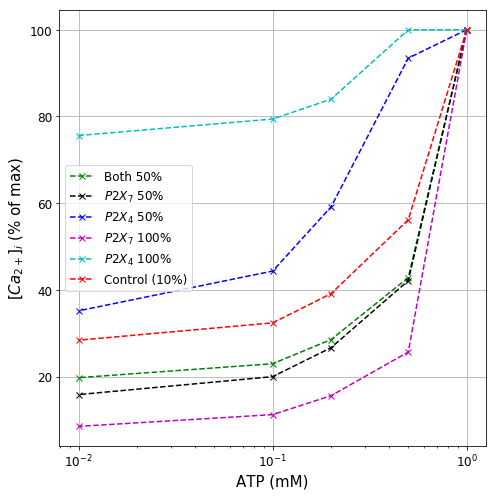

In [82]:
plt.figure(figsize = (7,7))
atp = np.array([1,0.5,0.2,0.1,0.01])
plt.tick_params(labelsize=12)
plt.semilogx(atp,rCa1,'g--x',label="Both 50%")
plt.semilogx(atp,rCa21,'k--x',label="$P2X_{7}$ 50%")
plt.semilogx(atp,rCa31,'b--x',label="$P2X_{4}$ 50%")
plt.semilogx(atp,rCa61,'m--x',label="$P2X_{7}$ 100%")
plt.semilogx(atp,rCa51,'c--x',label="$P2X_{4}$ 100%")
plt.semilogx(atp,rCa71,'r--x',label="Control (10%)")
plt.legend(loc=0,fontsize=12)
plt.xlabel("ATP (mM)",fontsize=15)
plt.ylabel("$[Ca_{2+}]_{i}$ (% of max)",fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig("LogplotRelativeCaMaxAllConditions.png")

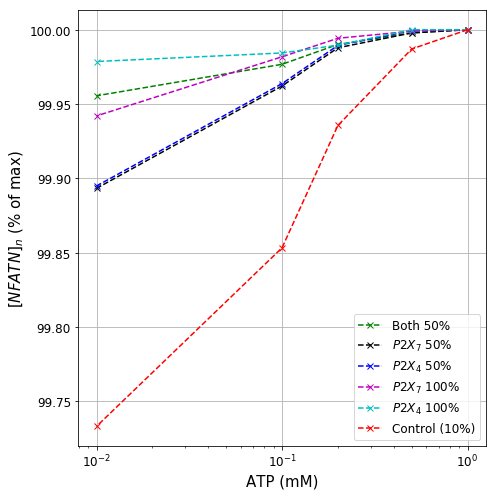

In [21]:
plt.figure(figsize = (7,7))
atp = np.array([1,0.5,0.2,0.1,0.01])
plt.tick_params(labelsize=12)
plt.semilogx(atp,rNFAT1,'g--x',label="Both 50%")
plt.semilogx(atp,rNFAT21,'k--x',label="$P2X_{7}$ 50%")
plt.semilogx(atp,rNFAT31,'b--x',label="$P2X_{4}$ 50%")
plt.semilogx(atp,rNFAT61,'m--x',label="$P2X_{7}$ 100%")
plt.semilogx(atp,rNFAT51,'c--x',label="$P2X_{4}$ 100%")
plt.semilogx(atp,rNFAT71,'r--x',label="Control (10%)")
plt.legend(loc=0,fontsize=12)
plt.xlabel("ATP (mM)",fontsize=15)
plt.ylabel("$[NFATN]_{n}$ (% of max)",fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig("LogplotRelativeNFATMaxAllConditions.png")

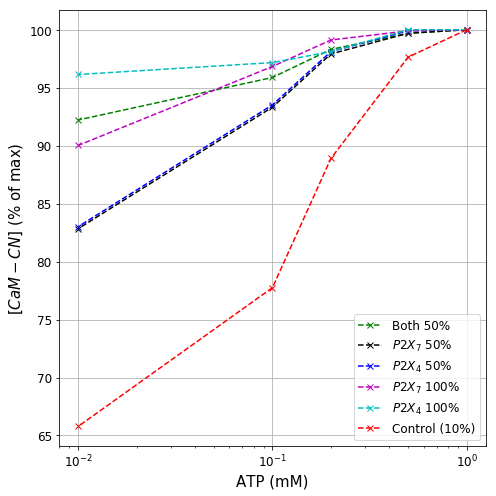

In [22]:
plt.figure(figsize = (7,7))
atp = np.array([1,0.5,0.2,0.1,0.01])
plt.tick_params(labelsize=12)
plt.semilogx(atp,rCaMCN1,'g--x',label="Both 50%")
plt.semilogx(atp,rCaMCN21,'k--x',label="$P2X_{7}$ 50%")
plt.semilogx(atp,rCaMCN31,'b--x',label="$P2X_{4}$ 50%")
plt.semilogx(atp,rCaMCN61,'m--x',label="$P2X_{7}$ 100%")
plt.semilogx(atp,rCaMCN51,'c--x',label="$P2X_{4}$ 100%")
plt.semilogx(atp,rCaMCN71,'r--x',label="Control (10%)")
plt.legend(loc=0,fontsize=12)
plt.xlabel("ATP (mM)",fontsize=15)
plt.ylabel("$[CaM-CN]$ (% of max)",fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig("LogplotRelativeCaMCNMaxAllConditions.png")

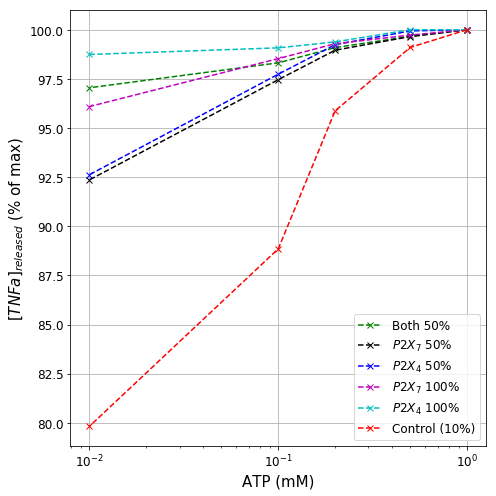

In [23]:
plt.figure(figsize = (7,7))
atp = np.array([1,0.5,0.2,0.1,0.01])
plt.tick_params(labelsize=12)
plt.semilogx(atp,rTNF1,'g--x',label="Both 50%")
plt.semilogx(atp,rTNF21,'k--x',label="$P2X_{7}$ 50%")
plt.semilogx(atp,rTNF31,'b--x',label="$P2X_{4}$ 50%")
plt.semilogx(atp,rTNF61,'m--x',label="$P2X_{7}$ 100%")
plt.semilogx(atp,rTNF51,'c--x',label="$P2X_{4}$ 100%")
plt.semilogx(atp,rTNF71,'r--x',label="Control (10%)")
plt.legend(loc=0,fontsize=12)
plt.xlabel("ATP (mM)",fontsize=15)
plt.ylabel("$[TNFa]_{released}$ (% of max)",fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig("LogplotRelativeTNFMaxAllConditions.png")

In [88]:
CaMAX10 = np.array([Camax1,Camax21,Camax31,Camax61,Camax51,Camax71])
rCa10 = CaMAX10/(max(CaMAX10))*100
CaMAX20 = np.array([Camax2,Camax22,Camax32,Camax62,Camax52,Camax72])
rCa20 = CaMAX20/(max(CaMAX20))*100
CaMAX30 = np.array([Camax3,Camax23,Camax33,Camax63,Camax53,Camax73])
rCa30 = CaMAX30/(max(CaMAX30))*100
CaMAX40 = np.array([Camax4,Camax24,Camax34,Camax64,Camax54,Camax74])
rCa40 = CaMAX40/(max(CaMAX40))*100
CaMAX50 = np.array([Camax5,Camax25,Camax35,Camax65,Camax55,Camax75])
rCa50 = CaMAX50/(max(CaMAX50))*100

CaMCNMAX10 = np.array([CaMCNmax1,CaMCNmax21,CaMCNmax31,CaMCNmax61,CaMCNmax51,CaMCNmax71])
rCaMCN10 = CaMCNMAX10/(max(CaMCNMAX10))*100
CaMCNMAX20 = np.array([CaMCNmax2,CaMCNmax22,CaMCNmax32,CaMCNmax62,CaMCNmax52,CaMCNmax72])
rCaMCN20 = CaMCNMAX20/(max(CaMCNMAX20))*100
CaMCNMAX30 = np.array([CaMCNmax3,CaMCNmax23,CaMCNmax33,CaMCNmax63,CaMCNmax53,CaMCNmax73])
rCaMCN30 = CaMCNMAX30/(max(CaMCNMAX30))*100
CaMCNMAX40 = np.array([CaMCNmax4,CaMCNmax24,CaMCNmax34,CaMCNmax64,CaMCNmax54,CaMCNmax74])
rCaMCN40 = CaMCNMAX40/(max(CaMCNMAX40))*100
CaMCNMAX50 = np.array([CaMCNmax5,CaMCNmax25,CaMCNmax35,CaMCNmax65,CaMCNmax55,CaMCNmax75])
rCaMCN50 = CaMCNMAX50/(max(CaMCNMAX50))*100


NFATMAX10 = np.array([NFATmax1,NFATmax21,NFATmax31,NFATmax61,NFATmax51,NFATmax71])
rNFAT10 = NFATMAX10/(max(NFATMAX10))*100
NFATMAX20 = np.array([NFATmax2,NFATmax22,NFATmax32,NFATmax62,NFATmax52,NFATmax72])
rNFAT20 = NFATMAX20/(max(NFATMAX20))*100
NFATMAX30 = np.array([NFATmax3,NFATmax23,NFATmax33,NFATmax63,NFATmax53,NFATmax73])
rNFAT30 = NFATMAX30/(max(NFATMAX30))*100
NFATMAX40 = np.array([NFATmax4,NFATmax24,NFATmax34,NFATmax64,NFATmax54,NFATmax74])
rNFAT40 = NFATMAX40/(max(NFATMAX40))*100
NFATMAX50 = np.array([NFATmax5,NFATmax25,NFATmax35,NFATmax65,NFATmax55,NFATmax75])
rNFAT50 = NFATMAX50/(max(NFATMAX50))*100


TNFMAX10 = np.array([TNFmax1,TNFmax21,TNFmax31,TNFmax61,TNFmax51,TNFmax71])
rTNF10 = TNFMAX10/(max(TNFMAX10))*100
TNFMAX20 = np.array([TNFmax2,TNFmax22,TNFmax32,TNFmax62,TNFmax52,TNFmax72])
rTNF20 = TNFMAX20/(max(TNFMAX20))*100
TNFMAX30 = np.array([TNFmax3,TNFmax23,TNFmax33,TNFmax63,TNFmax53,TNFmax73])
rTNF30 = TNFMAX30/(max(TNFMAX30))*100
TNFMAX40 = np.array([TNFmax4,TNFmax24,TNFmax34,TNFmax64,TNFmax54,TNFmax74])
rTNF40 = TNFMAX40/(max(TNFMAX40))*100
TNFMAX50 = np.array([TNFmax5,TNFmax25,TNFmax35,TNFmax65,TNFmax55,TNFmax75])
rTNF50 = TNFMAX50/(max(TNFMAX50))*100


In [93]:
print(TNFMAX10)

[ 44.90454932  44.90426711  44.77653589  44.94314791  44.52010293
  44.77329711]


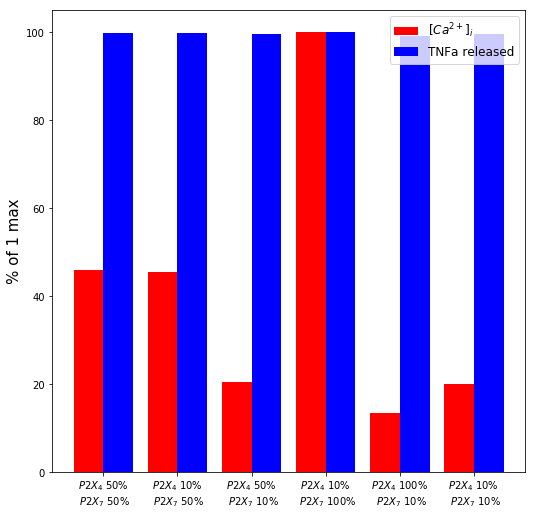

In [94]:
plt.figure(figsize=(14,7))
plt.tick_params(labelsize=12)
ax = plt.subplot(1,2,1)
b1 = ax.bar(1-0.2,rCa10[0],0.4,color="red",alpha=1)
b2 = ax.bar(1+0.2,rTNF10[0],0.4,color="blue",alpha=1)
b3 = ax.bar(2-0.2,rCa10[1],0.4,color="red",alpha=1)
b4 = ax.bar(2+0.2,rTNF10[1],0.4,color="blue",alpha=1)
b5 = ax.bar(3-0.2,rCa10[2],0.4,color="red",alpha=1)
b6 = ax.bar(3+0.2,rTNF10[2],0.4,color="blue",alpha=1)
b7 = ax.bar(4-0.2,rCa10[3],0.4,color="red",alpha=1)
b8 = ax.bar(4+0.2,rTNF10[3],0.4,color="blue",alpha=1)
b9 = ax.bar(5-0.2,rCa10[4],0.4,color="red",alpha=1)
b10 = ax.bar(5+0.2,rTNF10[4],0.4,color="blue",alpha=1)
b11 = ax.bar(6-0.2,rCa10[5],0.4,color="red",alpha=1)
b12 = ax.bar(6+0.2,rTNF10[5],0.4,color="blue",alpha=1)
plt.tight_layout()
ax.set_ylabel("% of 1 max",fontsize=15)
ax.legend((b1[0],b2[0]),('$[Ca^{2+}]_{i}$','TNFa released'),loc=0,fontsize=12)
newInd = np.array([1,2,3,4,5,6])
ax.set_xticks(newInd)
ax.set_xticklabels(['$P2X_{4}$ 50% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 50% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 100%',
                    '$P2X_{4}$ 100% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 10%'],fontsize=10)
plt.savefig("BarVariedDensityCavsTNFat1mM.png")

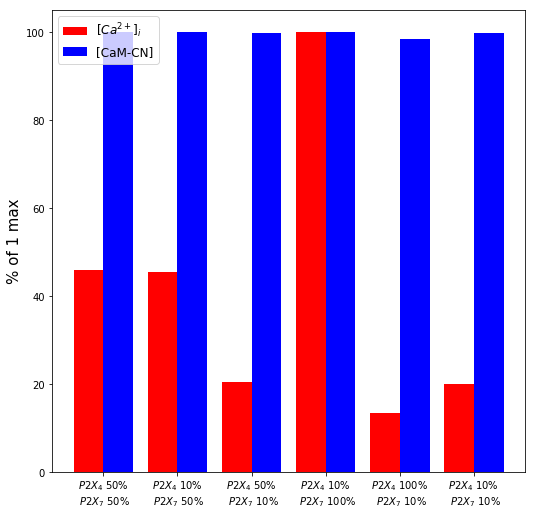

In [95]:
plt.figure(figsize=(14,7))
plt.tick_params(labelsize=12)
ax = plt.subplot(1,2,1)
b1 = ax.bar(1-0.2,rCa10[0],0.4,color="red",alpha=1)
b2 = ax.bar(1+0.2,rCaMCN10[0],0.4,color="blue",alpha=1)
b3 = ax.bar(2-0.2,rCa10[1],0.4,color="red",alpha=1)
b4 = ax.bar(2+0.2,rCaMCN10[1],0.4,color="blue",alpha=1)
b5 = ax.bar(3-0.2,rCa10[2],0.4,color="red",alpha=1)
b6 = ax.bar(3+0.2,rCaMCN10[2],0.4,color="blue",alpha=1)
b7 = ax.bar(4-0.2,rCa10[3],0.4,color="red",alpha=1)
b8 = ax.bar(4+0.2,rCaMCN10[3],0.4,color="blue",alpha=1)
b9 = ax.bar(5-0.2,rCa10[4],0.4,color="red",alpha=1)
b10 = ax.bar(5+0.2,rCaMCN10[4],0.4,color="blue",alpha=1)
b11 = ax.bar(6-0.2,rCa10[5],0.4,color="red",alpha=1)
b12 = ax.bar(6+0.2,rCaMCN10[5],0.4,color="blue",alpha=1)
plt.tight_layout()
ax.set_ylabel("% of 1 max",fontsize=15)
ax.legend((b1[0],b2[0]),('$[Ca^{2+}]_{i}$','[CaM-CN]'),loc=0,fontsize=12)
newInd = np.array([1,2,3,4,5,6])
ax.set_xticks(newInd)
ax.set_xticklabels(['$P2X_{4}$ 50% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 50% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 100%',
                    '$P2X_{4}$ 100% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 10%'],fontsize=10)
plt.savefig("BarVariedDensityCavsCaMCNat1mM.png")

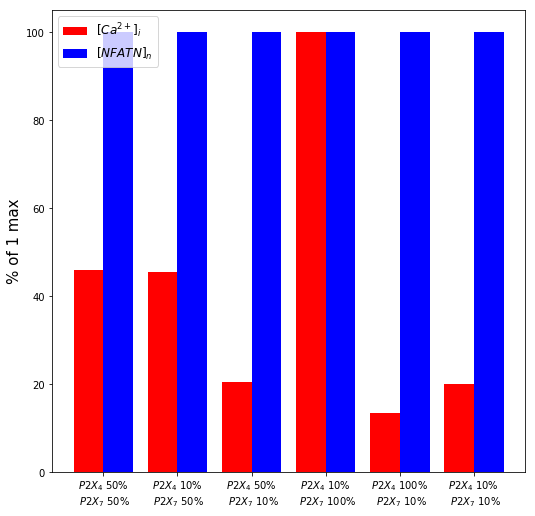

In [98]:
plt.figure(figsize=(14,7))
plt.tick_params(labelsize=12)
ax = plt.subplot(1,2,1)
b1 = ax.bar(1-0.2,rCa10[0],0.4,color="red",alpha=1)
b2 = ax.bar(1+0.2,rNFAT10[0],0.4,color="blue",alpha=1)
b3 = ax.bar(2-0.2,rCa10[1],0.4,color="red",alpha=1)
b4 = ax.bar(2+0.2,rNFAT10[1],0.4,color="blue",alpha=1)
b5 = ax.bar(3-0.2,rCa10[2],0.4,color="red",alpha=1)
b6 = ax.bar(3+0.2,rNFAT10[2],0.4,color="blue",alpha=1)
b7 = ax.bar(4-0.2,rCa10[3],0.4,color="red",alpha=1)
b8 = ax.bar(4+0.2,rNFAT10[3],0.4,color="blue",alpha=1)
b9 = ax.bar(5-0.2,rCa10[4],0.4,color="red",alpha=1)
b10 = ax.bar(5+0.2,rNFAT10[4],0.4,color="blue",alpha=1)
b11 = ax.bar(6-0.2,rCa10[5],0.4,color="red",alpha=1)
b12 = ax.bar(6+0.2,rNFAT10[5],0.4,color="blue",alpha=1)
plt.tight_layout()
ax.set_ylabel("% of 1 max",fontsize=15)
ax.legend((b1[0],b2[0]),('$[Ca^{2+}]_{i}$','$[NFATN]_{n}$'),loc=0,fontsize=12)
newInd = np.array([1,2,3,4,5,6])
ax.set_xticks(newInd)
ax.set_xticklabels(['$P2X_{4}$ 50% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 50% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 100%',
                    '$P2X_{4}$ 100% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 10%'],fontsize=10)
plt.savefig("BarVariedDensityCavsNFATat1mM.png")

/home/AD/bch265/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


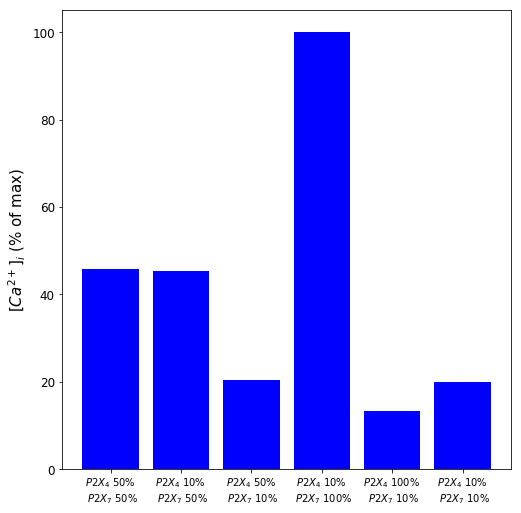

In [101]:
plt.figure(figsize=(7,7))
plt.tick_params(labelsize=12)
ax = plt.subplot(1,1,1)
b1 = ax.bar(1,rCa10[0],0.8,color="blue",alpha=1)
b2 = ax.bar(2,rCa10[1],0.8,color="blue",alpha=1)
b3 = ax.bar(3,rCa10[2],0.8,color="blue",alpha=1)
b4 = ax.bar(4,rCa10[3],0.8,color="blue",alpha=1)
b5 = ax.bar(5,rCa10[4],0.8,color="blue",alpha=1)
b6 = ax.bar(6,rCa10[5],0.8,color="blue",alpha=1)
plt.tight_layout()
ax.set_ylabel("$[Ca^{2+}]_{i}$ (% of max)",fontsize=15)
newInd = np.array([1,2,3,4,5,6])
ax.set_xticks(newInd)
ax.set_xticklabels(['$P2X_{4}$ 50% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 50%',
                    '$P2X_{4}$ 50% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 100%',
                    '$P2X_{4}$ 100% \n $P2X_{7}$ 10%',
                    '$P2X_{4}$ 10% \n $P2X_{7}$ 10%'],fontsize=10)
plt.savefig("BarVariedDensityCaat1mM.png")